In [1]:
# %pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from  sklearn.naive_bayes import MultinomialNB
from  sklearn.naive_bayes import BernoulliNB
from  sklearn.linear_model import SGDClassifier
from  sklearn.linear_model import PassiveAggressiveClassifier

import numpy as np
from tqdm import tqdm

import pickle


import os

# Configuration

In [2]:
data_path = '../data/MIT-BIH/'
minute_input = 10
minute_output = 10
window_input= 40*minute_input
window_out= 40*minute_input
train_size = 0.8
test_size = 1 - train_size
# data_set = {
#   0: "test",
#   1: "train"
# }

data_set = {
  0: "test_ram",
  1: "train_ram"
}

# length_ecg là độ dài 2 khoảng RR được fixed lúc tiền xử lý dữ liệu 
# (độ dài một dòng trong file excel, trừ cột cuối là nhãn lớp bệnh tim)
length_ecg = 187 
batch_size = 16
model_cls = "LSTM"
'''
Độ dài của input/output càng dài thì số lượng file không đáp ứng đủ để tạo một mẫu hợp lệ 
cho mô hình càng nhiều. Để đám bảo tính thống nhất nên sẽ dùng độ dài dài nhất của phần 
input/output trong quá trình thực nghiệm để là chuẩn từ đó loại các file bị thiếu này đều
ở những phần thực nghiệm input/output khác.
'''
missing_file_train = ['201_V1.csv', '102_V2.csv', '124_V4.csv', '112_V1.csv', '203_V1.csv', '116_V1.csv', '108_V1.csv', '207_V1.csv', '111_V1.csv', '200_V1.csv', '207_MLII.csv', '210_V1.csv', '202_V1.csv', '113_V1.csv', '214_V1.csv', '121_V1.csv', '109_V1.csv', '105_V1.csv', '107_V1.csv', '115_V1.csv', '208_V1.csv']
missing_file_test = ['213_V1.csv', '231_V1.csv', '228_V1.csv', '222_V1.csv', '232_V1.csv']

# Training Regression

## Get data

In [3]:
def get_data(istrainset):    
    missing_file = []
    total_sample = 0
    directory = f"{data_path}{data_set[istrainset]}/"
    X, y = [], []
    for filename in os.listdir(directory):
        if (filename not in (missing_file_train)) and (filename not in (missing_file_test)) and (filename != ".DS_Store"):
            f = os.path.join(directory, filename)
            if os.path.isfile(f):
                df = pd.read_csv(f, header=None)
                data=df.drop(columns=length_ecg)
                data=data.values
                data1=df.iloc[:, length_ecg]
                # Số lượng lặp qua dữ liệu
                num_samples = len(data) - window_input - 1 - window_out
                # Tạo dữ liệu train từ cửa sổ trượt
                if num_samples > 0:
                    total_sample = total_sample + num_samples
                    for i in range(num_samples):
                        X_window = data[i:i+window_input]
                        y_value = data1[i+window_input+window_out]

                        X.append(X_window)
                        y.append(y_value)
                else:
                    missing_file.append(filename)
    print("------🍒------")
    print(f"Num of file in {data_set[istrainset]} set can not use due to its missing of length: {len(missing_file)}")
    print(f"Number of sample: {len(y)}/{len(X)}/{total_sample}")
    print(f"Missing files: {missing_file}")
    return X,y
   

In [4]:
# # Lấy tập train/test
X_train, y_train = get_data(1)
X_test, y_test = get_data(0)

------🍒------
Num of file in train_ram set can not use due to its missing of length: 0
Number of sample: 3995/3995/3995
Missing files: []
------🍒------
Num of file in test_ram set can not use due to its missing of length: 0
Number of sample: 2400/2400/2400
Missing files: []


In [5]:
class Dataset:
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # read data
        X = self.data[i]
        y = self.label[i].astype(int)
        return X, y

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size,size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size= size

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return self.size //self.batch_size

In [6]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

In [7]:
train_loader = Dataloader(train_dataset, batch_size,len(train_dataset))
test_loader = Dataloader(test_dataset,batch_size,len(test_dataset))

## Build Model

In [19]:
def build_model_cls(model_name,epochs):
    # Tạo một mô hình LSTM
    if model_name == "LSTM":
        input_shape = (window_input, length_ecg)
        model= Sequential()
        model.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(5, activation='softmax'))

        # Compile model
        learning_rate = 0.00000001
        adam = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)        
        model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    elif model_name == "SGDClassifier":
        model = SGDClassifier(learning_rate = 'constant', eta0 = 0.1, shuffle = False, max_iter = 1)
    elif model_name == "MultinomialNB":
        model = MultinomialNB(learning_rate = 'constant', eta0 = 0.1, shuffle = False, max_iter = 1)
    elif model_name == "BernoulliNB":
        model = BernoulliNB(learning_rate = 'constant', eta0 = 0.1, shuffle = False, max_iter = 1)
    elif model_name == "PassiveAggressiveClassifier":
        model = PassiveAggressiveClassifier(learning_rate = 'constant', eta0 = 0.1, shuffle = False, max_iter = 1)
    elif model_name == "SVMRBF":
        model = SVC(kernel='rbf', C=1.0, gamma='scale')

    return model

## DL Algorithm

### LSTM

In [ ]:
model_name = "LSTM"
epochs = 2
model = build_model_cls(model_name, epochs = epochs)
model.fit(train_loader, validation_data=test_loader, verbose=1, epochs=epochs)
model.save(f"trained/{model_name}_PastECG_FutureCls_{minute_input}-mininput_{minute_output}-minoutput.h5")
print("Saved model to disk")

## ML Algorithm

### SVMBRF for batch_size ram issue

In [16]:
model_name = "SGDClassifier"
epochs = 2
model = build_model_cls(model_name, epochs = epochs)

for k in range(epochs):
    print(f"-----Epoch {k+1}/{epochs}------")
    for i in tqdm(range(len(train_loader))):
        X_train_batch = train_loader[i][0]
        y_train_batch = train_loader[i][1]
        

        # Generate some sample data
        X_train_batch = X_train_batch.reshape(batch_size, window_input*length_ecg)

        model.partial_fit(X_train_batch,y_train_batch, classes=list(range(5)))

pkl_filename = f"trained/{model_name}_PastECG_FutureCls_{minute_input}-mininput_{minute_output}-minoutput.sav"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

-----Epoch 1/2------


100%|██████████| 249/249 [00:02<00:00, 97.34it/s] 


-----Epoch 2/2------


100%|██████████| 249/249 [00:02<00:00, 103.09it/s]


In [11]:
pkl_filename = f"trained/{model_name}_PastECG_FutureCls_{minute_input}-mininput_{minute_output}-minoutput.sav"
loaded_model = pickle.load(open(pkl_filename, 'rb'))



y_pred_all = np.array([])
for i in tqdm(range(len(test_loader))):
    X_train_batch = train_loader[i][0]

    X_test_batch = test_loader[i][0]
    y_test_batch = test_loader[i][1]
    

    # # Generate some sample data
    X_test_batch = X_test_batch.reshape(batch_size, window_input*length_ecg)

    Y_preds = loaded_model.predict(X_test_batch)

    y_pred_all = np.append(y_pred_all, Y_preds)

100%|██████████| 150/150 [00:01<00:00, 91.08it/s] 


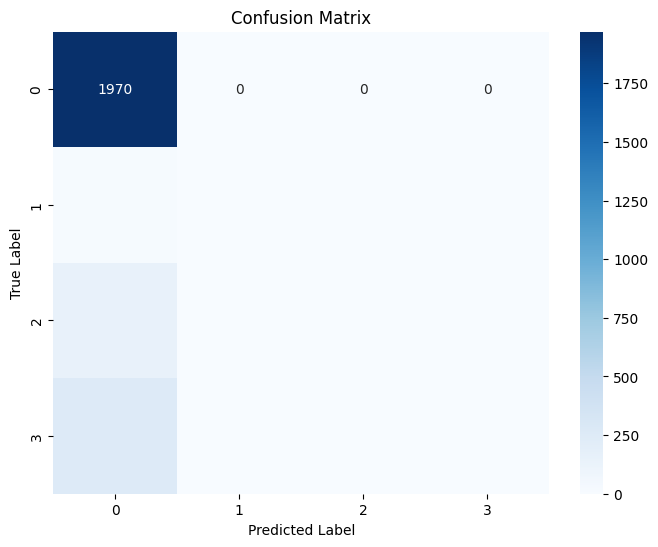

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### SVMBRF for not care about ram issue

In [ ]:
# def get_data_for_ml(istrainset):    
#     missing_file = []
#     total_sample = 0
#     directory = f"{data_path}{data_set[istrainset]}/"
#     X, y = [], []
#     for filename in os.listdir(directory):
#         if (filename not in (missing_file_train)) and (filename not in (missing_file_test)) and (filename != ".DS_Store"):
#             f = os.path.join(directory, filename)
#             if os.path.isfile(f):
#                 df = pd.read_csv(f, header=None)
#                 data=df.drop(columns=length_ecg)
#                 data=data.values
#                 data1=df.iloc[:, length_ecg]
#                 # Số lượng lặp qua dữ liệu
#                 num_samples = len(data) - window_input - 1 - window_out
#                 # Tạo dữ liệu train từ cửa sổ trượt
#                 if num_samples > 0:
#                     total_sample = total_sample + num_samples
#                     for i in range(num_samples):
#                         X_window = data[i:i+window_input]
#                         y_value = data1[i+window_input+window_out]

#                         X.append(X_window.reshape(window_input*length_ecg))
#                         y.append(y_value)
#                 else:
#                     missing_file.append(filename)
#     print("------🍒------")
#     print(f"Num of file in {data_set[istrainset]} set can not use due to its missing of length: {len(missing_file)}")
#     print(f"Number of sample: {len(y)}/{len(X)}/{total_sample}")
#     print(f"Missing files: {missing_file}")
#     return X,y

In [ ]:
# # # Lấy tập train/test
# X_train, y_train = get_data_for_ml(1)
# X_test, y_test = get_data_for_ml(0)

In [ ]:
# model_name = "SVMRBF"
# epochs = 2
# model = build_model_cls(model_name, epochs = epochs)

# model.fit(X_train, y_train)

# pkl_filename = f"trained/{model_name}_PastECG_FutureCls_{minute_input}-mininput_{minute_output}-minoutput.sav"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)